In [ ]:
from torchvision import datasets
import torch
data_folder = '/my_data/'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12763917.27it/s]


Extracting /my_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /my_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204881.41it/s]


Extracting /my_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /my_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3748267.87it/s]


Extracting /my_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /my_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20702087.24it/s]

Extracting /my_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /my_data/FashionMNIST/raw



In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [ ]:
from torch.optim import SGD, Adam

def get_model(): #utiliza um modelo com uma camada de convolução seguida de um pooling, isso realizado 2 vezes, modelo apresentado na seção de autoencoders
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=3200, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train_dataset = FMNISTDataset(tr_images, tr_targets)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = FMNISTDataset(val_images, val_targets)
    val_dataloader = DataLoader(val_dataset, batch_size=len(val_images), shuffle=True)

    return train_dataloader, val_dataloader

In [ ]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model,loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


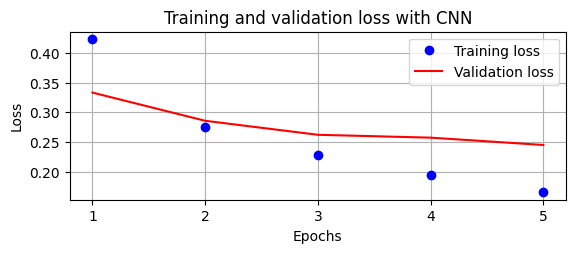

<ipython-input-13-7a9e3eea833f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


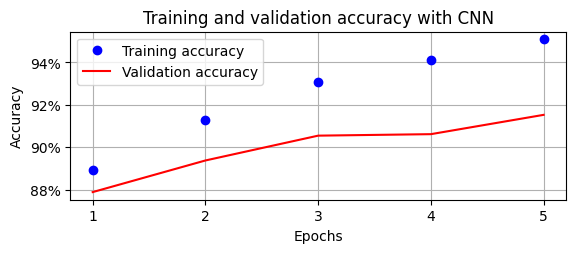

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show() #a disparidade entre precisão de treino e validação representa falsos positivos, o que é normal, porém deve ser tratada quando em altas quantidades

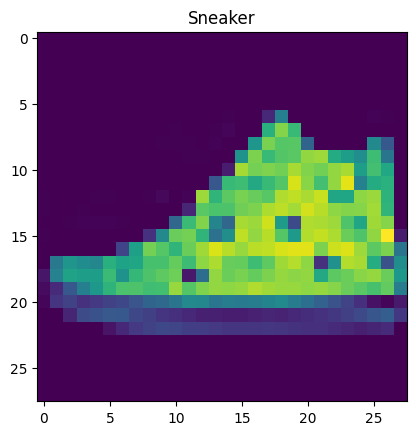

229


In [ ]:
ix = 223 #itera pelo dataset, incrementando o indice até achar um sapato, e o mostra juntamente com seu indice
while True:
    img = tr_images[ix] / 255.
    img = img.view(28, 28)



    img3 = torch.Tensor(img).view(-1, 1, 28, 28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output) / np.sum(np.exp(np_output))

    if fmnist.classes[pred.argmax()] == 'Sneaker':
        plt.imshow(img2)
        plt.title(fmnist.classes[pred.argmax()])
        plt.show()
        print(ix)
        break
    else:
        ix += 1


In [ ]:
fmnist.classes[pred.argmax()]

'Sneaker'